# Imports

In [1]:
import os
import cv2
import pickle
import mediapipe as mp
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Dataset Creation

In [2]:
data_directory = './data'
number_of_classes = 24
dataset_size = 100

In [4]:
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

In [5]:
cap = cv2.VideoCapture(1)

In [7]:
for i in range(number_of_classes):
    if not os.path.exists(os.path.join(data_directory, str(i))):
        os.makedirs(os.path.join(data_directory, str(i)))

    print('Collecting data for class number {}'.format(i))

    done = False
    while True:
        ret, frame = cap.read()
        cv2.putText(frame, 'Ready? Press "Q")', (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 4,cv2.LINE_AA)
        cv2.imshow('frame', frame)
        if cv2.waitKey(25) == ord('q'):
            break

    counter = 0
    while counter < dataset_size:
        ret, frame = cap.read()
        cv2.imshow('frame', frame)
        cv2.waitKey(25)
        cv2.imwrite(os.path.join(data_directory, str(i), '{}.jpg'.format(counter)), frame)

        counter += 1

cap.release()
cv2.destroyAllWindows()

# Pre processing

In [3]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [4]:
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

In [5]:
for dir in range(3,4):
    dir = str(dir)
    for img_path in os.listdir(os.path.join(data_directory, dir)):
        img = cv2.imread(os.path.join(data_directory, dir, img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        results = hands.process(img_rgb)

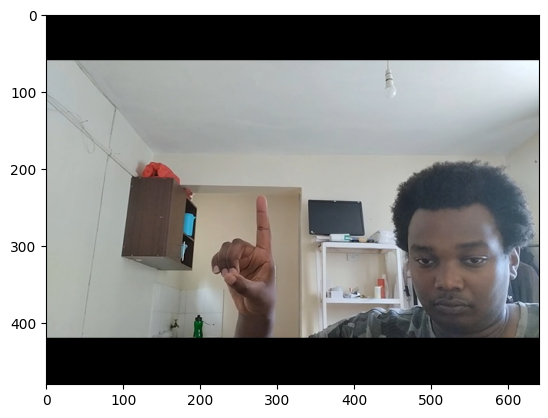

In [6]:
plt.figure()
plt.imshow(img_rgb)

In [7]:
mp_drawing.draw_landmarks(img_rgb, 
                          results.multi_hand_landmarks[0],
                          mp_hands.HAND_CONNECTIONS, 
                          mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=4),
                          mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=2))

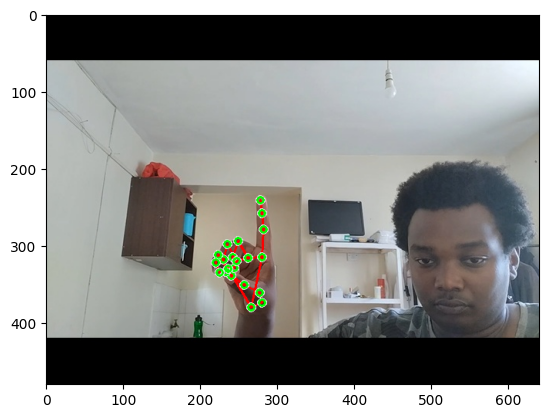

In [8]:
plt.figure()
plt.imshow(img_rgb)

In [9]:
data = []
labels = []

for dir in os.listdir(data_directory):
    for img_path in os.listdir(os.path.join(data_directory, dir)):
        
        data_aux = []

        x = []
        y = []

        img = cv2.imread(os.path.join(data_directory, dir, img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        results = hands.process(img_rgb)
        
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                for i in range(len(hand_landmarks.landmark)):
                    x_coord = hand_landmarks.landmark[i].x
                    y_coord = hand_landmarks.landmark[i].y

                    x.append(x_coord)
                    y.append(y_coord)

                for i in range(len(hand_landmarks.landmark)):
                    x_coord = hand_landmarks.landmark[i].x
                    y_coord = hand_landmarks.landmark[i].y
                    data_aux.append(x_coord - min(x))
                    data_aux.append(y_coord - min(y))

            data.append(data_aux)
            labels.append(dir)


In [12]:
f = open('data.pickle', 'wb')
pickle.dump({'data': data, 'labels': labels}, f)
f.close()

# Training

In [24]:
data_dict = pickle.load(open('./data.pickle', 'rb'))

In [23]:
data = np.empty([2400,42])

In [30]:
for i in range(len(data_dict["data"])):
    for j in range(len(data_dict["data"][0])):
        data_array[i][j] = data_dict["data"][i][j]

In [34]:
labels = np.asarray(data_dict['labels'])

In [36]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels)

In [37]:
model = RandomForestClassifier()

In [38]:
model.fit(x_train, y_train)

RandomForestClassifier()

In [39]:
predictions = model.predict(x_test)

In [40]:
score = accuracy_score(predictions, y_test)

print('{}% of samples were classified correctly !'.format(score * 100))

100.0% of samples were classified correctly !


In [41]:
f = open('model.p', 'wb')
pickle.dump({'model': model}, f)
f.close()